In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences

df = pd.read_csv('./fixed_cleaned_file.csv')
participants = df.pop('participant')

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

X = [df_scaled[participants == pid].values for pid in participants.unique()]

X_padded = pad_sequences(X, padding='post', dtype='float32')

print(f"Shape of Input Data: {X_padded.shape}")


Shape of Input Data: (99, 207, 28)


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X_padded, test_size=0.2, random_state=42)


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [4]:
# Define LSTM Autoencoder Model
timesteps = X_padded.shape[1]
n_features = X_padded.shape[2]

# Encoder
input_layer = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = LSTM(32, activation='relu', return_sequences=False)(encoded)

# Decoder
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)

# Output Layer (reconstruct input)
output_layer = TimeDistributed(Dense(n_features))(decoded)

# Compile the Autoencoder
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 207, 28)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 207, 64)        │        23,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 207, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 207, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 207, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 207, 28)        │         1,820 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,196 (278.11 KB)

 Trainable params: 71,196 (278.11 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = autoencoder.fit(X_train, X_train,
                          epochs=100,
                          batch_size=32,
                          validation_data=(X_test, X_test),
                          verbose=1)

autoencoder.save('keystroke_lstm_autoencoder.h5')


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 0.1613 - val_loss: 0.1559
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 509ms/step - loss: 0.1560 - val_loss: 0.1463
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - loss: 0.1441 - val_loss: 0.1127
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - loss: nan - val_loss: nan   
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 532ms/step - loss: nan - val_loss: nan
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 553ms/step - loss: nan - val_loss: nan
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 599ms/step - loss: nan - val_loss: nan
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 558ms/step - loss: nan - val_loss: nan
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 520ms/step - loss: nan - val_loss: nan
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step - loss: nan - val_loss: nan
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 599ms/step - loss: nan - val_loss: nan
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - loss: nan - val_loss: nan
Epoch 13/100
3/3 ━━━━━━━━━━━━━

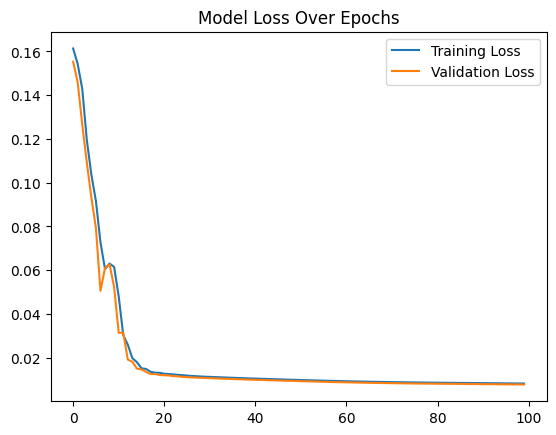

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()


In [ ]:
reconstructed = autoencoder.predict(X_test)
mse_per_timestep = np.mean(np.square(X_test - reconstructed), axis=2)
sequence_index = 0
print(f"Reconstruction Errors (MSE) for Sequence {sequence_index}:")
print(mse_per_timestep[sequence_index])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Reconstruction Errors (MSE) for Sequence 0:
[0.05520183 0.00541067 0.00388143 0.00231228 0.00124563 0.00324447
 0.0023146  0.00264799 0.00129673 0.00158994 0.00155835 0.00165558
 0.00219604 0.00153484 0.0017819  0.00169916 0.00171731 0.00177243
 0.00172249 0.00154806 0.0024237  0.00160091 0.00166795 0.00220693
 0.00147602 0.00171802 0.00167153 0.00194341 0.00118257 0.00198483
 0.00145729 0.00181929 0.00172245 0.00175903 0.00179724 0.0017982
 0.00149648 0.00166902 0.00184096 0.00222284 0.00129872 0.00211025
 0.00194854 0.00149005 0.00243248 0.00137377 0.00223704 0.00173913
 0.00184415 0.00135926 0.00147814 0.00170383 0.00203535 0.00161181
 0.00180829 0.00198908 0.00172189 0.00181361 0.0014171  0.00194147
 0.0015661  0.00203239 0.00174884 0.00145533 0.00125676 0.00170057
 0.00186691 0.00186041 0.00198755 0.00205917 0.00177881 0.00206267
 0.00204543 0.00182616 0.00199818 0.00141042 0.00212067 0.0017485
 0.00135975 0.00134348 0.00154986 0.0014045  0.0011

In [ ]:
threshold = np.percentile(mse_per_timestep, 95)
anomalous_positions = mse_per_timestep > threshold
print(f"Anomalous Time Steps in Sequence {sequence_index}:")
print(np.where(anomalous_positions[sequence_index]))


Anomalous Time Steps in Sequence 0:
(array([  0, 101, 200, 201, 202, 203, 204, 205, 206]),)


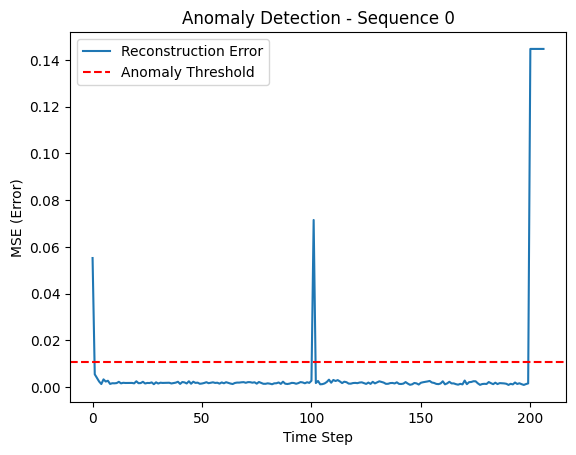

In [ ]:
import matplotlib.pyplot as plt
def plot_anomalies(sequence_index):
    plt.plot(mse_per_timestep[sequence_index], label='Reconstruction Error')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
    plt.title(f"Anomaly Detection - Sequence {sequence_index}")
    plt.xlabel("Time Step")
    plt.ylabel("MSE (Error)")
    plt.legend()
    plt.show()

plot_anomalies(sequence_index)


In [ ]:
# Detect if Ctrl+C or Ctrl+V occurs
ctrl_c_detected = 'DU.ctrl.c' in df.columns and (df['DU.ctrl.c'] > 0).any()
ctrl_v_detected = 'DU.ctrl.v' in df.columns and (df['DU.ctrl.v'] > 0).any()

if ctrl_c_detected or ctrl_v_detected:
    print("⚠️ Copy-Paste Behavior Detected!")
